# Model Domain

In [ ]:
#-----------------------Importing Libraries-----------------------#
# import os
# import flopy
# import pathlib
# import matplotlib.pyplot as plt
# import numpy as np
# import geopandas as gpd
# import pandas as pd
# import rasterio
# import pyproj
# import shutil
# import random
# import jupyter_book
# import pathlib as pl
# from pathlib import Path
# from rasterio.crs import CRS
# from rasterio.plot import show
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# from rasterio.transform import from_bounds
# from rasterio.transform import rowcol
# from rasterio.mask import mask
# from shapely.geometry import box, Point, Polygon, LineString
# from flopy.utils.binaryfile import HeadFile
# from scipy.interpolate import griddata
# from pprint import pformat
# from flopy.plot.styles import styles
# from matplotlib.lines import Line2D
# from flopy.mf6 import MFSimulation
# from matplotlib import cbook, cm
# from matplotlib.colors import LightSource
# from modflow_devtools.misc import get_env, timed

# Import Libraries
%run /Users/u4eeevmq/Documents/Python/HyporheicFloPy/VQuintana/common_imports.py

# Retrieve stored variables
%store -r md6_exe_path
%store -r md7_exe_path
%store -r sim_name
%store -r workspace
%store -r figs_path
%store -r gwf_name
%store -r mp7_name
%store -r gwf_ws
%store -r mp7_ws
%store -r headfile
%store -r head_filerecord
%store -r budgetfile
%store -r budget_filerecord
%store -r write
%store -r run
%store -r plot
%store -r plot_show
%store -r plot_save

# Retrieve model parameters
%store -r length_units
%store -r time_units
%store -r nper
%store -r cell_size_x
%store -r cell_size_y
%store -r gw_mod_depth
%store -r z
%store -r kh
%store -r kv
%store -r gw_offset
%store -r porosity
%store -r rch_iface
%store -r rch_iflowface
%store -r recharge_rate
%store -r nstp
%store -r perlen
%store -r tsmult

# Retrieve spatial data
%store -r hec_ras_crs
%store -r terrain_elevation
%store -r raster_transform
%store -r transform
%store -r raster_crs
%store -r output_raster
%store -r cropped_output_raster
%store -r ground_water_domain
%store -r left_boundary
%store -r right_boundary

Number of columns: 215
Number of rows: 192
Raster CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",29.6666666666667],PARAMETER["central_meridian",-100.333333333333],PARAMETER["standard_parallel_1",30.1166666666667],PARAMETER["standard_parallel_2",31.8833333333333],PARAMETER["false_easting",2296583.33333333],PARAMETER["false_northing",9842500],UNIT["US survey foot",0.304800609601219],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Grid CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],P

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_19072\3265979922.py:137: UserWarning: Warning: converting a masked element to nan.
  top[i, grid_col] = elevation_value


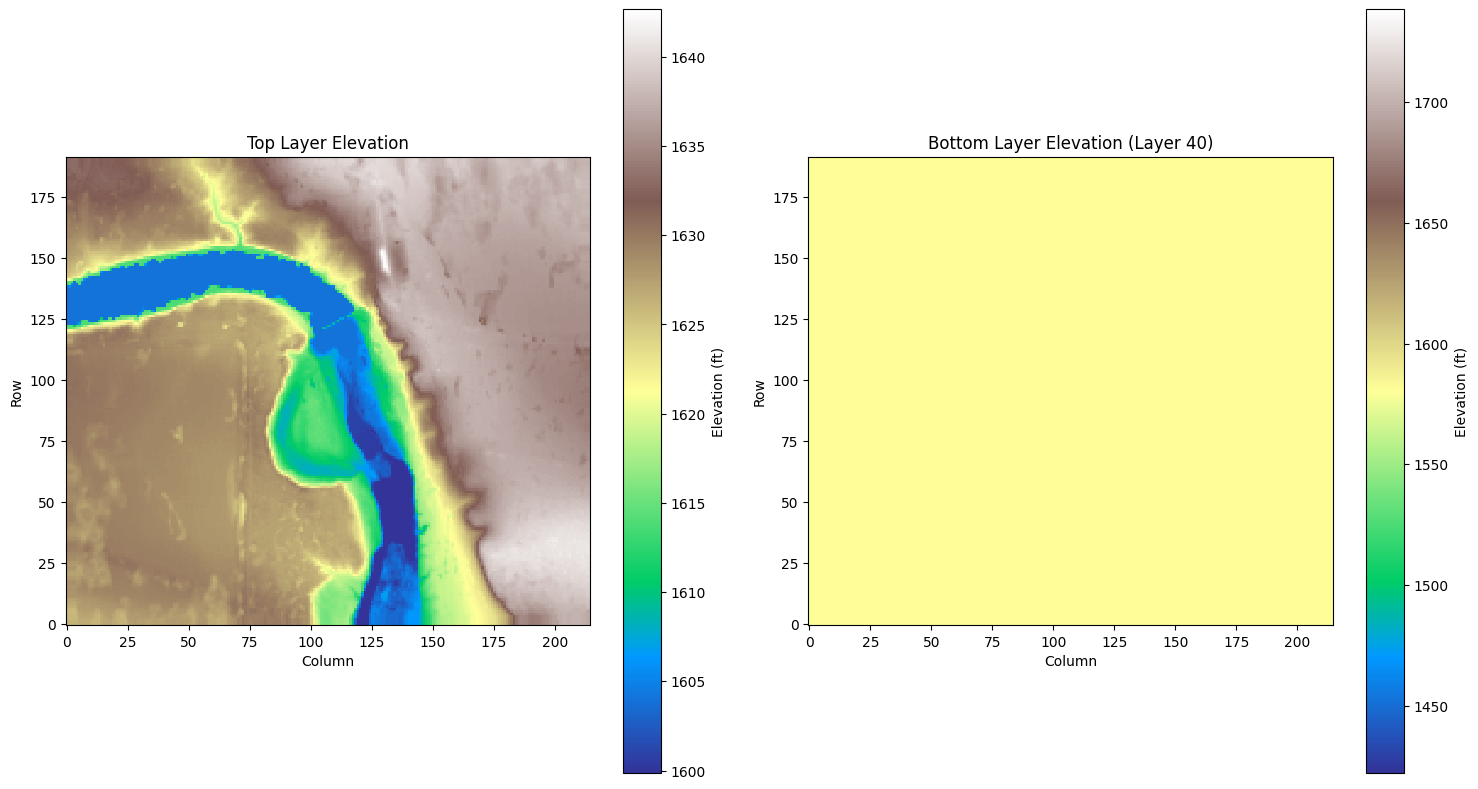

In [2]:
#------------------------------Model Grid--------------------------------#
## Plot Terrain Elevation
reprojected_terrain_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\reprojected_terrain_raster.tif"

# Read raster data and extract elevation values
with rasterio.open(reprojected_terrain_elevation_raster) as src:
    raster_array = src.read(1)  # Read the first band
    raster_transform = src.transform
    raster_crs = src.crs
    raster_bounds_box = box(*src.bounds)  # Create a shapely box for raster bounds
    terrain_elevation = np.ma.masked_equal(raster_array, src.nodata)  # Mask no-data values

# Find Bed Elevations
bed_elevation = np.min(terrain_elevation) # Bed elevation is the minimum value of the cropped surface elevation

# Calculate the extent of the raster
raster_width = src.width * transform[0]  # Width in feet
raster_height = src.height * abs(transform[4])  # Height in feet

# Determine the number of rows and columns based on the cell size
ncol = int(raster_width / cell_size_x)
nrow = int(raster_height / cell_size_y)

# Print the calculated grid dimensions
print(f'Number of columns: {ncol}')
print(f'Number of rows: {nrow}')

top = np.full((nrow, ncol), gw_mod_depth)  # feet below bed surface (depth of groundwater model)
nlay = int(top.max() / z)  # Number of groundwater layers based on default depth)

# Calculate grid cell centers
grid_x, grid_y = np.meshgrid(
    np.arange(0, ncol) * cell_size_x + (cell_size_x / 2),
    np.arange(0, nrow) * cell_size_y + (cell_size_y / 2),
)

# Convert cell centers to Points for intersection checks
grid_points = gpd.GeoDataFrame(
    {"geometry": [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]},
    crs= hec_ras_crs,  # Replace with the actual CRS of your grid
)

# Read raster data and extract elevation values
with rasterio.open(reprojected_terrain_elevation_raster) as src:
    raster_array = src.read(1)  # Read the first band
    raster_transform = src.transform
    raster_crs = src.crs
    raster_bounds_box = box(*src.bounds)  # Create a shapely box for raster bounds
    terrain_elevation = np.ma.masked_equal(raster_array, src.nodata)  # Mask no-data values

# Create a GeoDataFrame for raster bounds
raster_bounds_gdf = gpd.GeoDataFrame(
    {"geometry": [raster_bounds_box]}, crs=hec_ras_crs
)

# Reproject grid points to match raster CRS
# Use the raster bounds to define the grid extent
minx, miny, maxx, maxy = raster_bounds_box.bounds
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, ncol),
    np.linspace(miny, maxy, nrow),
)

# Recreate the grid points
grid_points = gpd.GeoDataFrame(
    {"geometry": [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]},
    crs=raster_crs,
)

# Check intersection between grid points and raster bounds
intersecting_points = grid_points[grid_points.geometry.intersects(raster_bounds_box)]

# Debugging: Print details about the GeoDataFrames
print(f"Raster CRS: {raster_bounds_gdf.crs}")
print(f"Grid CRS: {grid_points.crs}")
print(f"Number of grid points: {len(grid_points)}")
print(f"Number of intersecting points: {len(intersecting_points)}")

# Set x and y origin
xmin, ymin, xmax, ymax = raster_bounds_box.bounds  # Extract bounding box extent
xorigin = xmin  # Set xorigin to the left-most boundary
yorigin = ymin  # Set yorigin to the bottom-most boundary

# Store xmin, ymin, xmax, ymax
%store xmin
%store ymin
%store xmax
%store ymax

# Extract raster extent before looping
transform = raster_transform
xmin = transform.c
ymax = transform.f
xmax = xmin + (terrain_elevation.shape[1] * transform.a)
ymin = ymax + (terrain_elevation.shape[0] * transform.e)

print(f"✅ Raster Extent: X = ({xmin}, {xmax}), Y = ({ymin}, {ymax})")

# Function to interpolate NA values
def interpolate_na(terrain):
    # Get the coordinates of the non-masked values
    valid_mask = ~terrain.mask
    valid_coords = np.array(np.nonzero(valid_mask)).T
    valid_values = terrain[valid_mask]

    # Get the coordinates of the masked values
    invalid_mask = terrain.mask
    invalid_coords = np.array(np.nonzero(invalid_mask)).T

    # Interpolate the values at the masked coordinates
    interpolated_values = griddata(valid_coords, valid_values, invalid_coords, method='nearest')

    # Fill the masked values with the interpolated values
    terrain[invalid_mask] = interpolated_values

    return terrain

# Initialize the top array
top = np.full((nrow, ncol), np.nan)

# Update "top" values for each cell in the first layer based on surface elevation
for i in range(nrow):
    for grid_col in range(ncol):
        # Calculate the x, y coordinates of the cell center
        point_x = grid_x[i, grid_col]
        point_y = grid_y[i, grid_col]

        # Convert the grid cell center coordinates to raster indices
        col, row = ~raster_transform * (point_x, point_y)
        col, row = int(col), int(row)

        # Check if the indices are within raster bounds
        if 0 <= row < terrain_elevation.shape[0] and 0 <= col < terrain_elevation.shape[1]:
            elevation_value = terrain_elevation[row, col]

            # Update "top" based on the raster value
            top[i, grid_col] = elevation_value

# Interpolate any remaining NA values in the top array
top = interpolate_na(np.ma.masked_invalid(top))

## Initialize `tops` and `botm` lists
tops = [top]  # Add the top layer (surface elevation or default)
botm = []

# First layer bottom is calculated from the updated "top" values
first_layer_botm = np.full_like(top, bed_elevation)  # Subtract 0.5 ft for the first layer
botm.append(first_layer_botm)

# Create remaining layers with a constant thickness of 0.5 ft
for layer in range(1, 40):  # Layers 2 to 40
    next_layer_top = botm[-1]  # The top of the current layer is the bottom of the previous layer
    next_layer_botm = next_layer_top - z  # Subtract thickness from the top
    tops.append(next_layer_top)  # Add the top of the current layer
    botm.append(next_layer_botm)  # Add the bottom of the current layer

# Debugging: Check the top and bottom elevations for all layers
print("Top layer elevation (max, min):", tops[0].max(), botm[0].min())
for layer_idx in range(len(tops)):
    print(f"Layer {layer_idx + 1} top (max, min):", tops[layer_idx].max(), tops[layer_idx].min())
    print(f"Layer {layer_idx + 1} botm (max, min):", botm[layer_idx].max(), botm[layer_idx].min())
    
## Visualization: Plot the top and last bottom layers
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the top layer elevation
im1 = axs[0].imshow(top, cmap="terrain", interpolation="nearest", origin="lower")  # 🔹 Ensures (0,0) is bottom-left
axs[0].set_title("Top Layer Elevation")
axs[0].set_xlabel("Column")
axs[0].set_ylabel("Row")
fig.colorbar(im1, ax=axs[0], label="Elevation (ft)")

# Plot the bottom layer elevation (Layer 40)
im2 = axs[1].imshow(botm[-1], cmap="terrain", interpolation="nearest", origin="lower")  # 🔹 Ensures bottom-left
axs[1].set_title("Bottom Layer Elevation (Layer 40)")
axs[1].set_xlabel("Column")
axs[1].set_ylabel("Row")
fig.colorbar(im2, ax=axs[1], label="Elevation (ft)")

plt.tight_layout()
plt.show()

In [3]:
# Save Variables
%store terrain_elevation
%store raster_transform
%store raster_crs
%store raster_bounds_box
%store bed_elevation
%store raster_width
%store raster_height
%store ncol
%store nrow
%store top
%store nlay
%store grid_x
%store grid_y
%store grid_points
%store intersecting_points
%store xorigin
%store yorigin
%store tops
%store botm

Stored 'terrain_elevation' (MaskedArray)
Stored 'raster_transform' (Affine)
Stored 'raster_crs' (CRS)
Stored 'raster_bounds_box' (Polygon)
Stored 'bed_elevation' (float32)
Stored 'raster_width' (float)
Stored 'raster_height' (float)
Stored 'ncol' (int)
Stored 'nrow' (int)
Stored 'top' (MaskedArray)
Stored 'nlay' (int)
Stored 'grid_x' (ndarray)
Stored 'grid_y' (ndarray)
Stored 'grid_points' (GeoDataFrame)
Stored 'intersecting_points' (GeoDataFrame)
Stored 'xorigin' (float)
Stored 'yorigin' (float)
Stored 'tops' (list)
Stored 'botm' (list)
